**Set up all the neccessary libraries**

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

**Check if the GPU is available**

If there is a GPU available, the device will be cuda otherwise it will be cpu

In [2]:
# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cuda


**Load dataset**

In [3]:
base_path = r'C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification'

train_path = os.path.join(base_path, 'Training')
testing_path = os.path.join(base_path, 'Testing')

if not (os.path.exists(train_path) and os.path.exists(testing_path)):
    print('Failed to find the data path ')
else:
    print(f'Training path : {train_path}')
    print(f'Testing path : {testing_path}')

Training path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Training
Testing path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Testing


This CustomDataset class is a way to organize and load images for training a neural network in PyTorch. Here’s a breakdown of how it works in simple terms:

1. Initialization (__init__):
    When you create an instance of this class, you give it a folder path (root_dir) where your images are stored, and an optional transformation (transform) to apply to the images (e.g., resizing, normalization).
    The class looks inside the folder, and each subfolder is treated as a class (or category). For example, if you have two folders named 'cats' and 'dogs', the class assigns a label (like 0 for cats, 1 for dogs) to each folder.
    It then goes through each subfolder, collects the paths to the image files, and saves them in self.img_paths. At the same time, it keeps track of which class (or label) each image belongs to in self.labels.

2. Getting the dataset size (__len__):
    This method simply returns the number of images in the dataset. So if you have 1,000 images, this method will return 1,000.

3. Getting a single image and its label (__getitem__):
    When you ask for an image by its index (e.g., the 5th image), this method loads that image from the img_paths list.
    It converts the image to RGB format (since some images might have different color formats).
    It also fetches the corresponding label (like 0 for 'cat' or 1 for 'dog').
    If you provided any transformations (like resizing or normalizing), it applies them to the image.
    Finally, it returns both the processed image and its label.

In [4]:
# Define a Dataset class

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Mapping folder names to labels 
        class_folders = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_folder:idx for idx, class_folder in enumerate(class_folders)}

        for class_folder in class_folders:
            folder_path = os.path.join(root_dir,class_folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path,img_name)
                self.img_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_folder])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image,label

In [5]:
# Define your transform
transform = transforms.Compose([
    # Randomly flip the image horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Randomly flip the image vertically with a 50% chance
    transforms.RandomVerticalFlip(p=0.5),
    
    # Randomly rotate the image by ±10 degrees
    transforms.RandomRotation(degrees=10),
    
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Convert the image to a tensor with values in the range [0, 1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation
    # Use values based on your dataset, for example, for ImageNet:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the dataset
train_dataset = CustomDataset(root_dir=train_path, transform=transform)
test_dataset = CustomDataset(root_dir=testing_path, transform=transform)



# Calculate lengths for training and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])




# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False)

# Load the test dataset (remains unchanged)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# Test data loader

# Iterate through the data by batch
for image, label in train_loader:
    # Move the data to GPU for fast training
    img = image.to(device)
    label = label.to(device)

    # We put break here since we just want to check only a single batch of the data
    break

print(img.shape)
print(label.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


As can be seen, the structure of the data is organized as a torch tensor where the most left represents the batchsize followed by the number of channels, width, and height respectively.

And the label is a vector tensor of batch size representing the corresponding labels for each image.

**Define the Model**

**Why do we need nn.Module**

When creating a custom model in PyTorch, we subclass nn.Module because it provides essential functionalities and structure for building neural networks. Here’s why calling nn.Module is necessary:

1. Model Composition: nn.Module is a base class for all neural network modules in PyTorch. It allows you to define layers as attributes (e.g., self.conv, self.fc) and organize them in a coherent way. By subclassing nn.Module, you can easily group layers together and access them in the forward pass.

2. Parameter Management: When you define layers within a subclass of nn.Module, PyTorch automatically registers the parameters (weights and biases) of those layers. This allows the optimizer to access and update them during training without manual intervention.

3. Forward Propagation: By overriding the forward() method in your custom model, you define how data flows through the network. nn.Module provides a standardized way to define this behavior. You call model(input) and PyTorch internally invokes model.forward(input).

4. Module Nesting: nn.Module allows you to easily combine different submodules (like layers or blocks). For example, you can define smaller modules and nest them inside larger ones. This provides flexibility in designing complex architectures.

5. CUDA and Device Handling: nn.Module provides built-in methods like to(device) and cuda(), which automatically move all the model’s parameters to the correct device (CPU/GPU). Without subclassing nn.Module, you would need to manually manage this for each layer.


In [7]:

# Define the custom model
class MobileNetBT(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.2):
        super(MobileNetBT, self).__init__()
        # Load the pre-trained MobileNetV2 model
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        #freeze all layers
        for param in mobilenet.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom classifier
        self.features = mobilenet.features
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),  # Dropout layer with 20% probability
            nn.Linear(mobilenet.last_channel, 512),  # Linear layer with 1000 output features
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(p=dropout_prob),  # Additional dropout layer
            nn.Linear(512, num_classes)  # Final linear layer with 4 output classes
        )

        # Unfreeze the last 5 layers of MobileNetV2
        self.unfreeze_last_n_layers(mobilenet.features, 5)
        
    def unfreeze_last_n_layers(self, module, n):
        """
        Unfreeze the last `n` layers of a given module.
        """
        # Identify the named modules
        named_modules = list(module.named_children())
        # Iterate over the last `n` layers and unfreeze them
        for i, (name, child) in enumerate(named_modules[-n:]):
            for param in child.parameters():
                param.requires_grad = True
            print(f"Unfreezing layer: {name}")

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

In [8]:
# Instantiate the model
model = MobileNetBT(num_classes=4)
model = model.to(device)

Unfreezing layer: 14
Unfreezing layer: 15
Unfreezing layer: 16
Unfreezing layer: 17
Unfreezing layer: 18


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Check the number of parameters**

In this part, we can check the number of parameters that either require or don't require gradient update.

In [9]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f'The number of parameters : {total_params}')

The number of parameters : 2881796


In [10]:
# Calculate the total number of parameters that require gradient update
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The number of parameters that require gradient update: {total_params}')

The number of parameters that require gradient update: 2339268


In [11]:
# Calculate the total number of parameters that require gradient update
total_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"The number of parameters that don't require gradient update: {total_params}")

The number of parameters that don't require gradient update: 542528


Notice that the total number of parameters is equal to the combination of The number of parameters that require gradient update and The number of parameters that don't require gradient update

In [12]:
# Test the model and input compatability

test = model(img)

print(test.shape)

torch.Size([16, 4])


**Train**

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
num_epochs = 15
patience = 8
best_val_acc = 0.0
epochs_no_improve = 0

Epoch [1/15], Training Loss: 0.6840, Validation Accuracy: 0.8484
Best model saved!
Epoch [2/15], Training Loss: 0.4356, Validation Accuracy: 0.9164
Best model saved!
Epoch [3/15], Training Loss: 0.4124, Validation Accuracy: 0.8571
Epoch [4/15], Training Loss: 0.3087, Validation Accuracy: 0.9077
Epoch [5/15], Training Loss: 0.3172, Validation Accuracy: 0.8937
Epoch [6/15], Training Loss: 0.3118, Validation Accuracy: 0.9042
Epoch [7/15], Training Loss: 0.2646, Validation Accuracy: 0.8868
Epoch [8/15], Training Loss: 0.2764, Validation Accuracy: 0.9199
Best model saved!
Epoch [9/15], Training Loss: 0.1954, Validation Accuracy: 0.9477
Best model saved!
Epoch [10/15], Training Loss: 0.1674, Validation Accuracy: 0.9512
Best model saved!
Epoch [11/15], Training Loss: 0.1521, Validation Accuracy: 0.9460
Epoch [12/15], Training Loss: 0.1386, Validation Accuracy: 0.9564
Best model saved!
Epoch [13/15], Training Loss: 0.1451, Validation Accuracy: 0.9564
Epoch [14/15], Training Loss: 0.1145, Valid

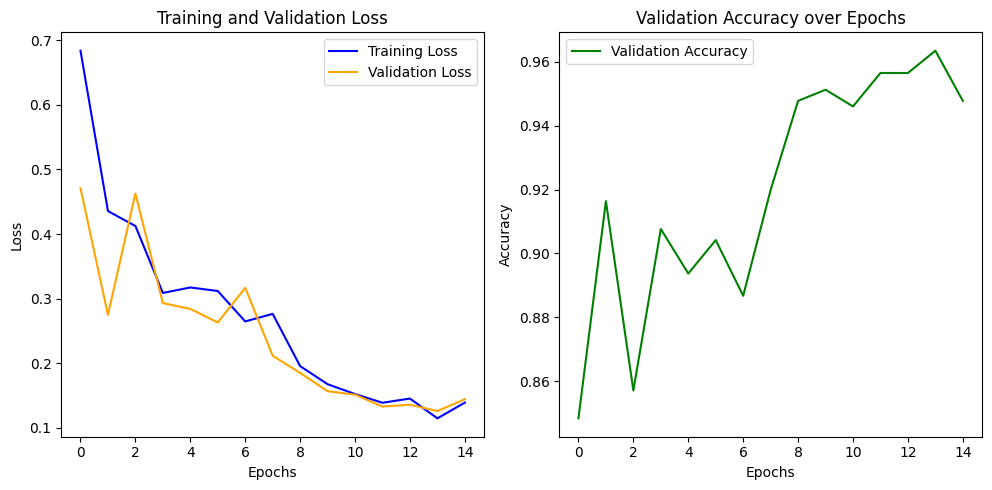

In [15]:
# Track loss and accuracy
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    avg_val_loss = running_val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Check if validation accuracy improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), f'BTC_at_{best_val_acc:.4f}.pth')
        print('Best model saved!')
    else:
        epochs_no_improve += 1

    # Adjust learning rate
    scheduler.step()

    # Check for early stopping
    if epochs_no_improve >= patience:
        print('Early stopping!')
        break

# Plot training and validation loss
plt.figure(figsize=(15, 5))

# Training and validation loss
plt.subplot(1, 3, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()